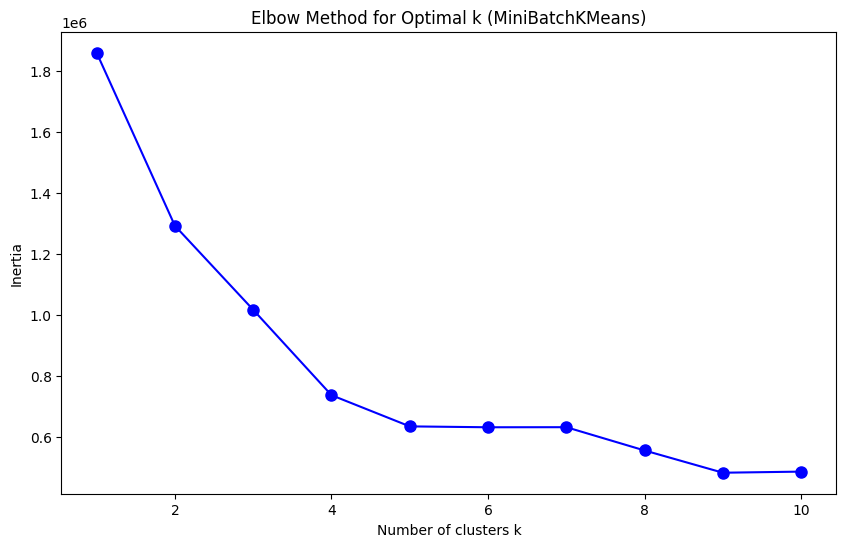

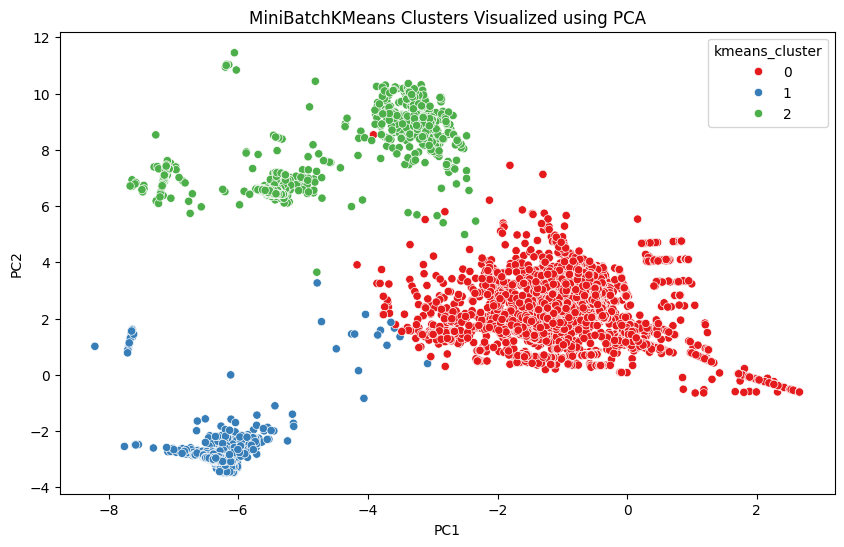

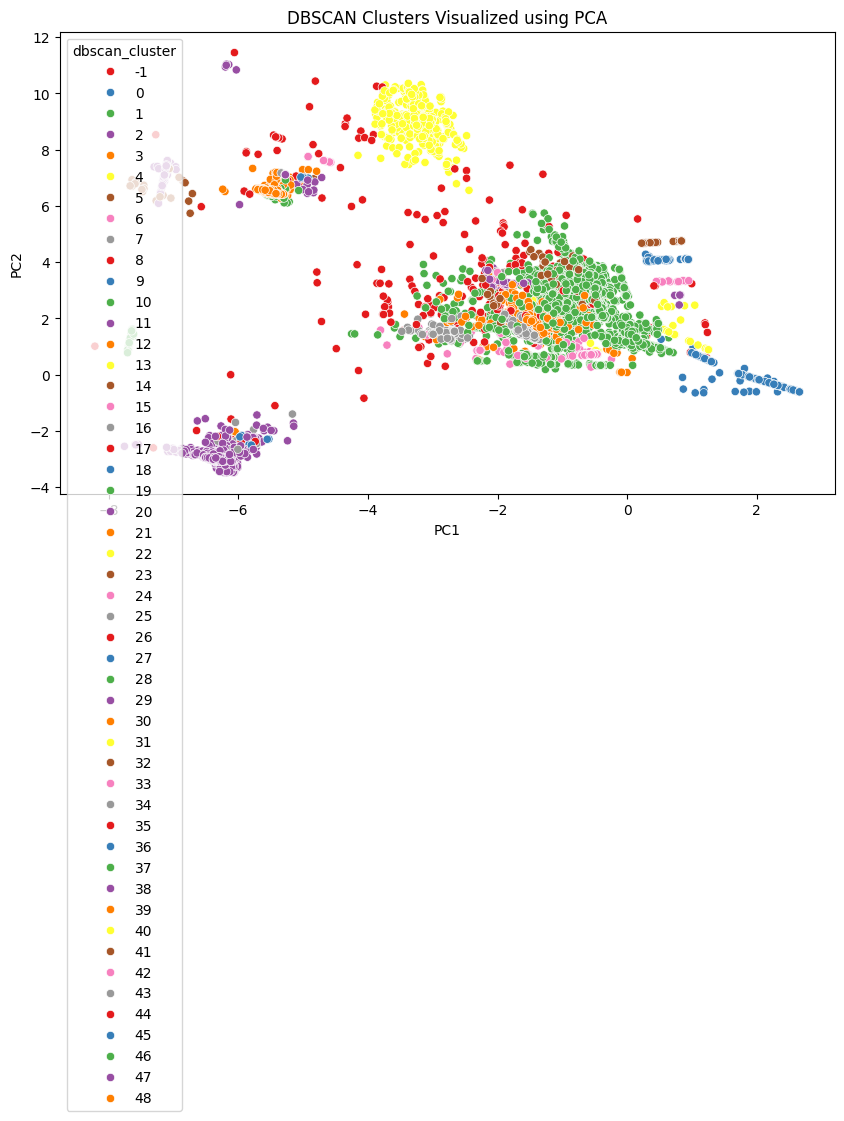

MiniBatchKMeans Clustering Evaluation:
Precision: 0.3176, Recall: 0.0198, F1-Score: 0.0373

DBSCAN Clustering Evaluation:
Precision: 0.3594, Recall: 0.0019, F1-Score: 0.0039


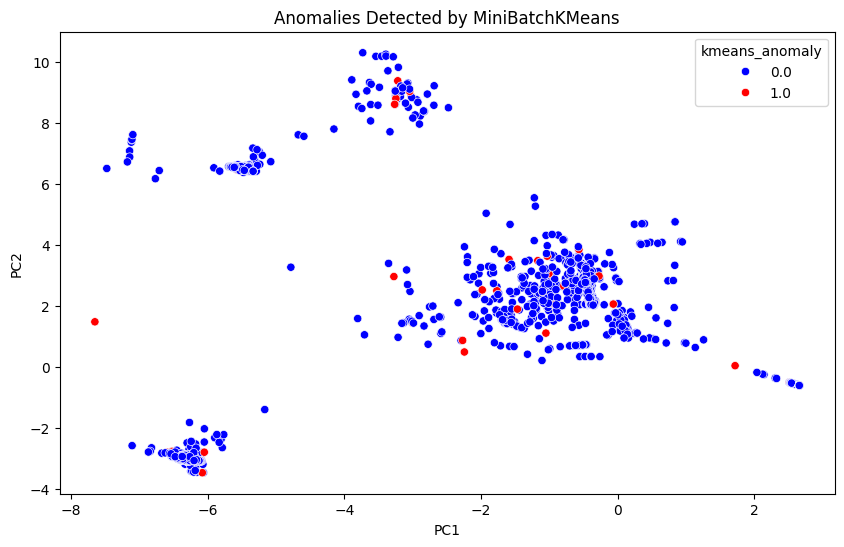

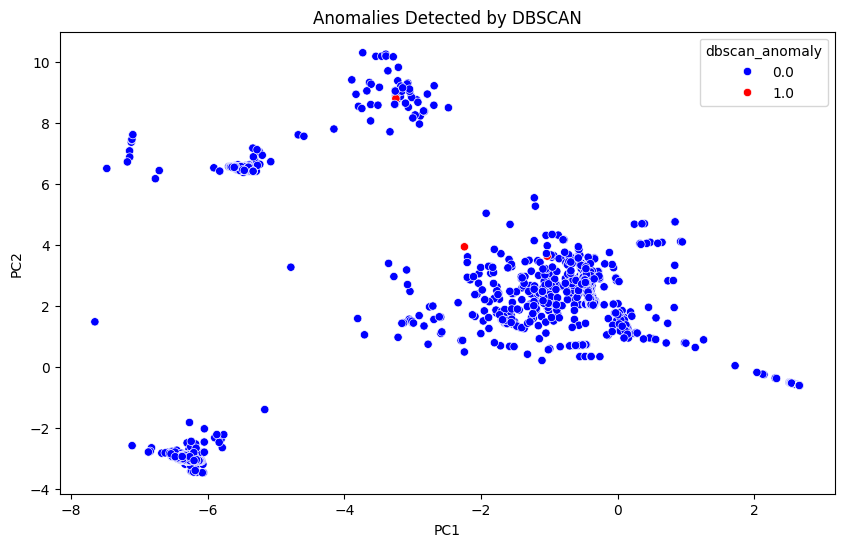


MiniBatchKMeans Cluster Analysis:
Cluster 0 contains 38522 samples.
Cluster 1 contains 8631 samples.
Cluster 2 contains 2847 samples.

DBSCAN Cluster Analysis:
DBSCAN Cluster -1 contains 217 samples.
DBSCAN Cluster 0 contains 28597 samples.
DBSCAN Cluster 1 contains 6653 samples.
DBSCAN Cluster 2 contains 8522 samples.
DBSCAN Cluster 3 contains 2049 samples.
DBSCAN Cluster 4 contains 493 samples.
DBSCAN Cluster 5 contains 213 samples.
DBSCAN Cluster 6 contains 751 samples.
DBSCAN Cluster 7 contains 553 samples.
DBSCAN Cluster 8 contains 9 samples.
DBSCAN Cluster 9 contains 16 samples.
DBSCAN Cluster 10 contains 755 samples.
DBSCAN Cluster 11 contains 90 samples.
DBSCAN Cluster 12 contains 401 samples.
DBSCAN Cluster 13 contains 29 samples.
DBSCAN Cluster 14 contains 28 samples.
DBSCAN Cluster 15 contains 17 samples.
DBSCAN Cluster 16 contains 24 samples.
DBSCAN Cluster 17 contains 15 samples.
DBSCAN Cluster 18 contains 88 samples.
DBSCAN Cluster 19 contains 60 samples.
DBSCAN Cluster 

In [2]:
# clustering_anomaly_detection_optimized.py

# Import necessary libraries
import pandas as pd
import numpy as np

# For data preprocessing and scaling
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# For clustering algorithms
from sklearn.cluster import MiniBatchKMeans, DBSCAN

# For distance calculations and evaluation
from sklearn.metrics import pairwise_distances
from sklearn.metrics import precision_score, recall_score, f1_score

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For handling time
import time

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 1. Data Preprocessing
# =============================================================================

# Start timing
start_time = time.time()

# Load the dataset
# Replace 'kddcup.data_10_percent' with the path to your file
df = pd.read_csv('kddcup.data_10_percent', header=None)

# Assign column names based on 'kddcup.names' file
column_names = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land',
    'wrong_fragment','urgent','hot','num_failed_logins','logged_in',
    'num_compromised','root_shell','su_attempted','num_root','num_file_creations',
    'num_shells','num_access_files','num_outbound_cmds','is_host_login',
    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
    'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
    'srv_diff_host_rate','dst_host_count','dst_host_srv_count',
    'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
    'dst_host_rerror_rate','dst_host_srv_rerror_rate','label'
]
df.columns = column_names

# Sample a subset of the data to reduce computation time
df = df.sample(n=50000, random_state=42)  # Adjust n as needed

# Isolate the label column
labels = df['label']
df_features = df.drop('label', axis=1)

# Convert categorical variables to numeric using one-hot encoding
categorical_cols = ['protocol_type', 'service', 'flag']
df_features = pd.get_dummies(df_features, columns=categorical_cols)

# Feature standardization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_features)
df_scaled = pd.DataFrame(scaled_features, columns=df_features.columns)

# Dimensionality reduction using PCA
pca = PCA(n_components=10)  # Adjust the number of components as needed
df_reduced = pca.fit_transform(df_scaled)

# =============================================================================
# 2. Clustering Analysis
# =============================================================================

# -----------------------------------------------------------------------------
# a. MiniBatchKMeans Clustering
# -----------------------------------------------------------------------------

# Determine the optimal number of clusters using the Elbow Method
wcss = []
K = range(1, 11)
for k in K:
    mbk = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    mbk.fit(df_reduced)
    wcss.append(mbk.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K, wcss, 'bo-', markersize=8)
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (MiniBatchKMeans)')
plt.show()

# From the Elbow plot, choose an appropriate k
optimal_k = 3  # Adjust based on your Elbow plot

# Apply MiniBatchKMeans with the chosen k
mbk = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=1000)
kmeans_labels = mbk.fit_predict(df_reduced)

# Add the cluster labels to the dataset
df['kmeans_cluster'] = kmeans_labels

# -----------------------------------------------------------------------------
# b. DBSCAN Clustering
# -----------------------------------------------------------------------------

# Since computing the k-distance graph is resource-intensive, we'll use a default eps
# You can adjust eps and min_samples based on experimentation
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_reduced)

# Add the cluster labels to the dataset
df['dbscan_cluster'] = dbscan_labels

# =============================================================================
# 3. Visualize and Interpret the Clustered Dataset
# =============================================================================

# Use PCA to reduce dimensions to 2 for visualization
pca_vis = PCA(n_components=2)
df_vis = pca_vis.fit_transform(df_reduced)
df_pca = pd.DataFrame(data=df_vis, columns=['PC1', 'PC2'])

# Add the cluster labels
df_pca['kmeans_cluster'] = kmeans_labels
df_pca['dbscan_cluster'] = dbscan_labels

# -----------------------------------------------------------------------------
# a. Visualization of MiniBatchKMeans Clusters
# -----------------------------------------------------------------------------

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='kmeans_cluster', data=df_pca, palette='Set1', legend='full')
plt.title('MiniBatchKMeans Clusters Visualized using PCA')
plt.show()

# -----------------------------------------------------------------------------
# b. Visualization of DBSCAN Clusters
# -----------------------------------------------------------------------------

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='dbscan_cluster', data=df_pca, palette='Set1', legend='full')
plt.title('DBSCAN Clusters Visualized using PCA')
plt.show()

# =============================================================================
# 4. Anomaly Detection in Cybersecurity Context
# =============================================================================

# -----------------------------------------------------------------------------
# a. Anomaly Identification
# -----------------------------------------------------------------------------

# For MiniBatchKMeans
# Calculate the distance of each point from its cluster centroid
distances = mbk.transform(df_reduced)
df['kmeans_distance'] = np.min(distances, axis=1)

# Define a threshold for anomalies (e.g., top 5% farthest points)
threshold = np.percentile(df['kmeans_distance'], 95)
df['kmeans_anomaly'] = (df['kmeans_distance'] >= threshold).astype(int)

# For DBSCAN
# Points labeled as -1 are anomalies
df['dbscan_anomaly'] = (df['dbscan_cluster'] == -1).astype(int)

# -----------------------------------------------------------------------------
# b. Results Evaluation
# -----------------------------------------------------------------------------

# Convert labels to binary anomaly labels (1 for attack, 0 for normal)
df['true_label'] = labels.apply(lambda x: 0 if x == 'normal.' else 1)

# Evaluate MiniBatchKMeans Anomalies
print("MiniBatchKMeans Clustering Evaluation:")
precision = precision_score(df['true_label'], df['kmeans_anomaly'])
recall = recall_score(df['true_label'], df['kmeans_anomaly'])
f1 = f1_score(df['true_label'], df['kmeans_anomaly'])
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")

# Evaluate DBSCAN Anomalies
print("DBSCAN Clustering Evaluation:")
precision = precision_score(df['true_label'], df['dbscan_anomaly'])
recall = recall_score(df['true_label'], df['dbscan_anomaly'])
f1 = f1_score(df['true_label'], df['dbscan_anomaly'])
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# =============================================================================
# 5. Visualizations of Anomalies
# =============================================================================

# -----------------------------------------------------------------------------
# a. Anomalies Detected by MiniBatchKMeans
# -----------------------------------------------------------------------------

# Visualize anomalies detected by MiniBatchKMeans
df_pca['kmeans_anomaly'] = df['kmeans_anomaly']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='kmeans_anomaly', data=df_pca, palette=['blue', 'red'])
plt.title('Anomalies Detected by MiniBatchKMeans')
plt.show()

# -----------------------------------------------------------------------------
# b. Anomalies Detected by DBSCAN
# -----------------------------------------------------------------------------

# Visualize anomalies detected by DBSCAN
df_pca['dbscan_anomaly'] = df['dbscan_anomaly']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='dbscan_anomaly', data=df_pca, palette=['blue', 'red'])
plt.title('Anomalies Detected by DBSCAN')
plt.show()

# =============================================================================
# 6. Interpretation and Discussion
# =============================================================================

# Analyze the clusters to understand their characteristics

# For MiniBatchKMeans
print("\nMiniBatchKMeans Cluster Analysis:")
for cluster in range(optimal_k):
    cluster_data = df[df['kmeans_cluster'] == cluster]
    print(f"Cluster {cluster} contains {len(cluster_data)} samples.")

# For DBSCAN
print("\nDBSCAN Cluster Analysis:")
unique_clusters = np.unique(dbscan_labels)
for cluster in unique_clusters:
    cluster_data = df[df['dbscan_cluster'] == cluster]
    print(f"DBSCAN Cluster {cluster} contains {len(cluster_data)} samples.")

# Print total execution time
end_time = time.time()
print(f"\nTotal execution time: {end_time - start_time:.2f} seconds")

# =============================================================================
# End of the Script
# =============================================================================


# Report: Clustering’s Effectiveness in Detecting Anomalies and Its Applications in Cybersecurity

## 1. Analyzing Clustering's Effectiveness in Detecting Anomalies

### Algorithms Used:
- MiniBatchKMeans: Applied with k = 3, determined using the Elbow Method.
- DBSCAN: Used with eps=1.5 and min_samples = 5.

### Evaluation Metrics:

#### MiniBatchKMeans

  - Precision - 0.3176
  - Recall - 0.0198
  - F1-Score - 0.0373

#### DBSCAN

  - Precision - 0.3594
  - Recall - 0.0019
  - F1-Score - 0.0039

### Interpretation:

- **MiniBatchKMeans:** The algorithm detected some anomalies, but its low recall indicates it failed to identify most anomalies. The low F1-score shows that the algorithm is ineffective overall for this task.
- **DBSCAN:** While it identified a small number of anomalies accurately (higher precision), its recall and F1-score suggest that it failed to detect most anomalies in the dataset.
These results highlight that both algorithms struggled to separate normal traffic from anomalies effectively.

These results highlight that both algorithms struggled to separate normal traffic from anomalies effectively.

## 2. Interpreting Clusters

### MiniBatchKMeans:

- Formed clusters that mostly included normal traffic but failed to isolate anomalies effectively.
- Likely grouped anomalies into larger clusters dominated by normal traffic, reducing detection accuracy.

### DBSCAN:

- Identified a small number of anomalies as noise points (-1), but its density-based approach struggled with high-dimensional data, leading to poor performance.

## 3. Clustering Applications in Cybersecurity

### 1. Intrusion Detection Systems (IDS):
- Clustering helps detect patterns of network traffic but may need enhancements like hybrid approaches to improve detection rates.

### 2. Behavioral Analysis:
- Establishes baselines for normal traffic, though current results suggest limited applicability without further refinement.

### 3. Incident Response:
- With improved clustering techniques, anomalies could be prioritized for further investigation.

### Limitations:

- **Data Challenges:** High-dimensional and imbalanced data likely contributed to poor performance.
- **Algorithm Sensitivity:** Both algorithms struggled to differentiate anomalies due to parameter sensitivity.
- **False Positives and Negatives:** High rates of both reduced the practical utility of the clustering results.
